除了利用原始keras的`model.fit`來訓練模型之外，也可以利用`tf.GradientTape`來計算梯度做參數更新，這麼做的好處在於可操控性高，反過來就是繁瑣就是，看需求使用吧。

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
tf.__version__

'2.0.0'

接著下載MNIST資料集，在這之前先設置一個簡單的回傳資料的類別

In [3]:
class Data_Loader:
    def __init__(self):
        mnist = tf.keras.datasets.mnist
        (self.x_train, self.y_train), (self.x_test, self.y_test) = mnist.load_data()
        self.x_train = self.x_train = np.expand_dims(self.x_train / 255., -1)
        self.x_test = self.x_test = np.expand_dims(self.x_test / 255., -1)
    
    def batch_data(self, t_type='train', batch_size=32):        
        if t_type == 'train':
            index = np.random.randint(0, self.x_train.shape[0], batch_size)
            return self.x_train[index], self.y_train[index]
        elif t_type == 'test':
            index = np.random.randint(0, self.x_test.shape[0], batch_size)        
            return self.x_test[index], self.y_test[index]

簡單列印幾張照片來確認

In [4]:
data_loader = Data_Loader()

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

隨機取得10個索引

In [6]:
_x, y = data_loader.batch_data(batch_size=10)

In [7]:
y

array([2, 7, 0, 3, 0, 9, 9, 0, 9, 7], dtype=uint8)

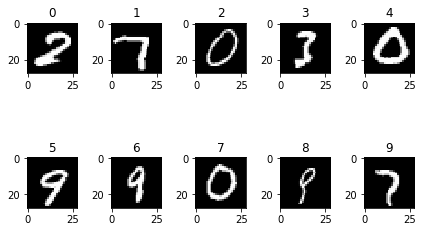

In [8]:
for idx in range(10):
    ax = plt.subplot(2, 5,idx+1)
    ax.imshow(_x[idx, :, :, 0], cmap='gray')
    plt.title(idx)    

plt.tight_layout()
plt.show()

指定硬體資源，相關可[參考](https://hackmd.io/@shaoeChen/ryWIV4vkL)

In [9]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')

In [10]:
gpus 

[PhysicalDevice(name=u'/physical_device:GPU:0', device_type=u'GPU'),
 PhysicalDevice(name=u'/physical_device:GPU:1', device_type=u'GPU')]

In [11]:
tf.config.experimental.set_visible_devices(devices=gpus[1], device_type='GPU')

In [12]:
tf.config.experimental.set_memory_growth(device=gpus[1], enable=True)

透過繼承`tf.keras.Model`來建構class

利用`tf.keras.Model`建構類別的時候要注意三點：
1. 初始化一定要繼承父類
2. 是`call`不是`__call__`
3. 不能使用`self.output`，因為這已經被用了

In [13]:
class LeNet5(tf.keras.Model):
    def __init__(self):
        # 一定要繼承父類的__init__才能使用父類相關的method與attribute
        super(LeNet5, self).__init__()
#         self.input = tf.keras.layers.InputLayer(input_shape=(28, 28, 1))
        self.conv1 = tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), padding='valid', activation='tanh')
        self.maxpool1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
        self.conv2 = tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), padding='valid', activation='tanh')
        self.maxpool2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(120, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(84, activation='tanh')
        self.pred_y = tf.keras.layers.Dense(10, activation='softmax')
    def call(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.pred_y(x)

確認模型

In [14]:
model = LeNet5()

編譯模型

這邊不再使用原始keras所提供的高階api-`model.compile`、`model.fit`做訓練，而是自定義細部，下面定義方式取自官方的入門範例，並自行修改

因為我們並未將label轉one-hot encoder，因此必需使用`sparse_categorical_crossentropy`做為loss function

首先定義最佳化方式、損失函數

In [15]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

定義度量方式

In [16]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')

利用`tf.GradientTape`訓練模型

In [17]:
def train_step(x, y):
    with tf.GradientTape() as tape:
        # 計算feedforward得到output
        predictions = model(x)
        # 計算實際與模型output的loss
        loss = loss_object(y, predictions)
    
    # 計算可訓練參數對損失函數的梯度
    gradients = tape.gradient(loss, model.trainable_variables)
    # 利用得到的梯度來更新參數
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(y, predictions)

In [22]:
%%time
# 迭代迴圈
for epoch in range(5):
    # 批次取資料迴圈
    for batch in range(int(60000/128)):        
        x, y = data_loader.batch_data(t_type='train', batch_size=128)
        train_step(x, y)
        

CPU times: user 34 s, sys: 1.39 s, total: 35.4 s
Wall time: 29 s


In [19]:
train_loss.result()

<tf.Tensor: id=400501, shape=(), dtype=float32, numpy=0.09765669>

In [20]:
train_accuracy.result()

<tf.Tensor: id=400505, shape=(), dtype=float32, numpy=0.9714076>

我們都注意到function-train_step中有這麼一段`train_loss(loss)`，而這個train_loss是來自於實作`tf.keras.metrics.Mean`，它的用途在於計算平均損失，見下範例：

In [25]:
m = tf.keras.metrics.Mean()

In [26]:
m(1)

<tf.Tensor: id=876883, shape=(), dtype=float32, numpy=1.0>

In [27]:
m(2)

<tf.Tensor: id=876893, shape=(), dtype=float32, numpy=1.5>

In [28]:
m(3)

<tf.Tensor: id=876903, shape=(), dtype=float32, numpy=2.0>

有注意到嗎?在執行`m(3)`的時候得到的結果是2.0，也就是(1+2+3)/3=2，因此你不需要再使用`model.loss`去取得模型的其它loss還加總平均的計算，或者是使用`loss = tf.reduce_mean(loss)`來平均，把事情交給框架吧。